<a href="https://colab.research.google.com/github/afafelwafi/DarijaCHAT/blob/main/sentiment_analysis_darija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ULMFiT on Arabic corpus

Original Dataset - [link](https://www.kaggle.com/abedkhooli/arabic-wiki-data-dump-2018).

The purpose is to build a language model for moroccan darija which can be used later in darija based chatbot 


In [ ]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai==1.0.28
! pip install tkseem
!pip install --user kaggle
!pip install transformers 

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
     |████████████████████████████████| 704.8 MB 5.4 kB/s 
     |████████████████████████████████| 120 kB 5.3 MB/s 
ERROR: Could not find a version that satisfies the requirement torchvision-nightly (from fastai) (from versions: none)
ERROR: No matching distribution found for torchvision-nightly
     |████████████████████████████████| 30.9 MB 1.6 MB/s 
     |████████████████████████████████| 1.2 MB 32.6 MB/s 
     |████████████████████████████████| 156 kB 51.8 MB/s 
     |████████████████████████████████| 843 kB 47.6 MB/s 
     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 61 kB 538 kB/s 
     |████████████████████████████████| 895 kB 39.4 MB/s 
     |████████████████████████████████| 3.3 MB 41.3 MB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3

In [ ]:
# Packages
import sys
import torch as torch
import pandas as pd
import numpy as np
from fastai import *
from fastai.text import *
import sklearn
import pickle
import json 

from tensorflow.keras.models import load_model
from tensorflow.keras import utils
from tensorflow.keras.metrics import Accuracy,Recall,Precision


# Get varaibels
f = open('variables.json')

# returns JSON object as a dictionary
variables = json.load(f)
path = Path(variables["path"])
bs = variables["bs"]

In [ ]:
# Mount folders 
from google.colab import drive
drive.mount('/content/drive/')

# Different folders 
dls_path = path/'dls'
model_path = path/'models'
spm_path = model_path/'spm'

dls_path.mkdir(exist_ok=True, parents=True)
model_path.mkdir(exist_ok=True, parents=True)
spm_path.mkdir(exist_ok=True, parents=True)


Mounted at /content/drive/


"\ndls_path = path/'dls'\nmodel_path = path/'models'\nspm_path = model_path/'spm'\n\ndls_path.mkdir(exist_ok=True, parents=True)\nmodel_path.mkdir(exist_ok=True, parents=True)\nspm_path.mkdir(exist_ok=True, parents=True)\n"

## Datasets

In [ ]:
!wget https://dumps.wikimedia.org/arywiki/latest/arywiki-latest-pages-articles.xml.bz2 -O '/content/drive/MyDrive/ml/projects/darija/arywiki-latest-pages-articles.xml.bz2'


--2022-01-10 13:15:28--  https://dumps.wikimedia.org/arywiki/latest/arywiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4999599 (4.8M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/ml/projects/darija/arywiki-latest-pages-articles.xml.bz2’

/content/drive/MyDr 100%[===================>]   4.77M  4.71MB/s    in 1.0s    

2022-01-10 13:15:29 (4.71 MB/s) - ‘/content/drive/MyDrive/ml/projects/darija/arywiki-latest-pages-articles.xml.bz2’ saved [4999599/4999599]



In [ ]:
from Utils.dataset import make_corpus
make_corpus(f'{path}/arywiki-latest-pages-articles.xml.bz2', f'{path}/wiki_darija.txt')

Processed 0 articles
Processed 1000 articles
Processed 2000 articles
Processed 3000 articles
Processing complete!


In [ ]:
df = pd.read_csv(path/'wiki_darija.txt', header=None, names=['text'])
df.head()

,text
0,أبطيح جماعة ترابية قروية كاينة إقليم طانطان جه...
1,آسفي بالأمازيغية ⴰⵙⴼⵉ هي مدينة مغربية جات إقلي...
2,آلبرخت دورر بالألمانية albrecht dürer ماي أبري...
3,آمتضي جماعة ترابية قروية كاينة إقليم عمالة ݣلم...
4,آنفݣ جماعة ترابية قروية كاينة إقليم عمالة سيدي...


In [ ]:
from Utils.preprocess import preprocess
df['text']=df['text'].apply(preprocess)
df.to_csv(path/'data_all.csv',index=False)

أبطيح جماعة ترابية قروية كاينة إقليم طانطان جهة ݣلميم واد نون ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة ݣلميم واد نون


## Language Model 
Will use a single text file for training, otherwise it would take ours to train on the entire dump.

In [ ]:
!head /content/drive/MyDrive/ml/projects/darija/data_all.csv

text
أبطيح جماعة ترابية قروية كاينة إقليم طانطان جهة ݣلميم واد نون ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة ݣلميم واد نون
آسفي بالأمازيغية هي مدينة مغربية جات إقليم آسفي جهة مراكش آسفي آسفي معروفة بالفخار والحوت وخصوصا السردين ومكنيين عليها حاضرة المحيط الحطة ديال آسفي جات كاطل على المحيط الأطلسي بين الجديدة والصويرة في آسفي كاين بزاف دالبني لي قديم وتاريخي وهي من بين المدون القديمة في المغرب ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي

In [ ]:
import tkseem as tk
tokenizer = fastai.text.Tokenizer(AutoTokenizer.from_pretrained("asafaya/bert-base-arabic"),'ar')
#arbic= tk.WordTokenizer()
#tokenizer = fastai.text.Tokenizer(SpacyTokenizer, 'ar') 
arabic =  fastai.text.Tokenizer(lang='ar')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(max_vocab=30000)]


In [ ]:
data_lm = TextLMDataBunch.from_csv(path, 'data_all.csv', tokenizer=arabic, bs=bs, header=None, text_cols=0, label_cols=None)
data_lm.save('tmp_lm')

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm = load_data(path,'tmp_lm', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,سبق ليهوم خدمو عيون لكلام تصنيف جهة الشرق xxbos رشيد شو هوا برنامج تلفزيوني xxunk على قناة دوزيم لعشية كل جمعة كايقدمو رشيد لعلالي كاينتامي xxunk xxunk شو كايجيب شخصيات xxunk مجالات مختالفة بحال لفن xxunk xxunk باش xxunk معاهم xxunk عليهم أسئلة على xxunk لحياتية xxunk وحتى الشخصية xxunk بعد لمرات بجدية بعض لمرات بطابع كوميدي كايتعتابر xxunk من أكتر برامج xxunk فتلفزة لمغربية وحاليا زاد واحد لفقرة جديدا
1,xxbos ڤالا ؤلا والا اتينية ؤلا هي مدينة مورية معروفة بلي كانت أبعد مدينة لجانوب ديال مملكة موريطانية وخا لعولاما ماشي متيقنين واش كانت تابعة ليها ؤلا لا لموضع ديال هاد لمدينة مامعروفش مي كاينة فرضية بلي هي نيت تارودانت لقديمة عيون لكلام شوف تا شالة باناصا تامودا وليلي تصنيف مدون مغربية أترية تصنيف مدون أترية مفقودة xxbos تاشاويت أول لأمازيغية xxunk هي واحد اللوغة من لفرع الزناتي ديال اللوغات
2,صدرات وزارة تقافة xxunk لخدمة لكاملة ديالو مجموعة لقصصية xxunk كل تلت سنين كاينا جائزة عالمية بسميتو كاتعطا مهرجان أزايلا كان أول واحد اها هوا وائي xxunk الطيب صالح لكتوبة ديالو حوار في ليل xxunk قصص وزارة الثقافة دمشق المرأة xxunk رواية الدار المتحدة xxunk بيروت xxunk xxunk رواية منشورات وزارة الإعلام العراقية بغداد xxunk xxunk قصص دار النشر المغربية الدار البيضاء xxunk في xxunk رواية الدار العربية للكتاب تونس
3,لي متعلقة ين يعني xxunk دين علا سياسة كيما خاص ولة لعلمانية تكون كاتعامل مع ݣاع لمواطنين دياولها علا أساس بل راهم كاملين بحال بحال لحقوق كيفما كانت xxunk xxunk xxunk لبلدان لي ملونين لخضر هوما دول علمانية ماعندهومش دين محدد لبلدان لي لݣري هما دول ماشي علمانية عندهم دين محدد عيون لكلام تصنيف سياسة تصنيف دين وسياسة xxbos سيدي بوعثمان جماعة ترابية حضرية كاينة إقليم الرحامنة جهة مراكش آسفي
4,خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة ݣلميم واد نون xxbos الخبز الحافي هيا ريواية كاتعتابر من أشهر xxunk للكاتب لمغربي محمد شكري تكتبات لعربية داخلا فيها تا دارجة تاريفيت عام وترجمها نݣليزية پول بولز عام وترجمها لفرانساوية طاهر بنجلون عام لكن xxunk لعربية حتال


### Train
#### Training - phase 1
We can then put this in a learner object and trained. 

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


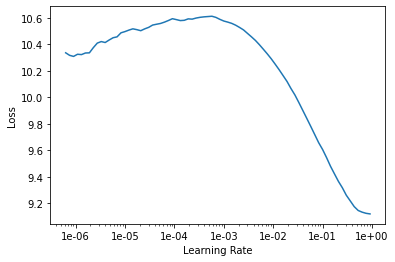

In [ ]:
learn.recorder.plot(skip_end=12)

In [ ]:
learn.fit_one_cycle(1, 5e-4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.960803,5.881003,0.346210,00:59


In [ ]:
learn.save('arwiki-1')

#### Training - phase 2
continue from last time saved weights

In [ ]:
bs=48
data_lm =  load_data(path,'tmp_lm', bs=bs)

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.load('arwiki-1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (3081 items)
x: LMTextList
xxbos ولاد xxunk جماعة ترابية قروية كاينة إقليم عمالة اظور جهة الشرق ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة الشرق,xxbos رشيد شو هوا برنامج تلفزيوني xxunk على قناة دوزيم لعشية كل جمعة كايقدمو رشيد لعلالي كاينتامي xxunk xxunk شو كايجيب شخصيات xxunk مجالات مختالفة بحال لفن xxunk xxunk باش xxunk معاهم xxunk عليهم أسئلة على xxunk لحياتية xxunk وحتى الشخصية xxunk بعد لمرات بجدية بعض لمرات بطابع كوميدي كايتعتابر xxunk من أكتر برامج xxunk فتلفزة لمغربية وحاليا زاد واحد لفقرة جديدا لبرنامج ولا كايجيب دراري صغار xxunk هادشي قبل ما xxunk على الضيف xxunk معاهم عيون لكلام تصنيف تلفازة,xxbos وليلي كرمة بن سالم سابقا جماعة

In [ ]:
learn.fit_one_cycle(10, 2e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.546811,5.774482,0.350158,00:59
1,6.677244,5.760563,0.350692,00:59
2,6.614880,5.735171,0.351847,00:59
3,6.531902,5.711151,0.352749,00:59
4,6.490153,5.692701,0.353405,00:59
5,6.411570,5.677476,0.353957,00:59
6,6.462697,5.667024,0.354377,00:59
7,6.345909,5.661224,0.354543,00:59
8,6.361349,5.660007,0.354482,00:59
9,6.274220,5.658783,0.354657,00:59


In [ ]:
learn.save('arwiki-2')

#### Training - phase 2
Continue from here for furter training

In [ ]:
learn.load('arwiki-2')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (3081 items)
x: LMTextList
xxbos ولاد xxunk جماعة ترابية قروية كاينة إقليم عمالة اظور جهة الشرق ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة الشرق,xxbos رشيد شو هوا برنامج تلفزيوني xxunk على قناة دوزيم لعشية كل جمعة كايقدمو رشيد لعلالي كاينتامي xxunk xxunk شو كايجيب شخصيات xxunk مجالات مختالفة بحال لفن xxunk xxunk باش xxunk معاهم xxunk عليهم أسئلة على xxunk لحياتية xxunk وحتى الشخصية xxunk بعد لمرات بجدية بعض لمرات بطابع كوميدي كايتعتابر xxunk من أكتر برامج xxunk فتلفزة لمغربية وحاليا زاد واحد لفقرة جديدا لبرنامج ولا كايجيب دراري صغار xxunk هادشي قبل ما xxunk على الضيف xxunk معاهم عيون لكلام تصنيف تلفازة,xxbos وليلي كرمة بن سالم سابقا جماعة

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


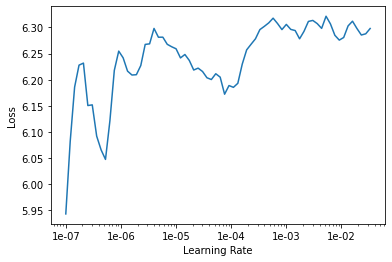

In [ ]:
learn.recorder.plot(0,30)

In [ ]:
learn.fit_one_cycle(10, 1e-45, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.344722,5.659828,0.354412,00:59
1,6.313970,5.660628,0.354394,00:59
2,6.270386,5.660350,0.354447,00:59
3,6.378734,5.659091,0.354552,00:59
4,6.287455,5.659360,0.354394,00:59
5,6.333154,5.659386,0.354543,00:59


KeyboardInterrupt: ignored

In [ ]:
learn.save('arwiki-3')

### Predict

In [ ]:
learn.load('arwiki-3')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (3081 items)
x: LMTextList
xxbos ولاد xxunk جماعة ترابية قروية كاينة إقليم عمالة اظور جهة الشرق ساكنين فيها واحد على حسب لإحصاء لعام تعليم نسبة لأمية اس ما كايعرفوش يقراو ولا يكتبو نسبة كان قاريين فوق انوي تانوي جامعة اقتصاد نسبة اس شيطين يقدرو يخدمو نسبة لبطالة اس ما خدامينش تايقلبو على خدمة نسبة اس اللي خدامين ولة ولا لعاطلين اللي سبق ليهوم خدمو نسبة اس اللي خدامين في لقطاع لخاص ولا لعاطلين اللي سبق ليهوم خدمو عيون لكلام تصنيف جهة الشرق,xxbos رشيد شو هوا برنامج تلفزيوني xxunk على قناة دوزيم لعشية كل جمعة كايقدمو رشيد لعلالي كاينتامي xxunk xxunk شو كايجيب شخصيات xxunk مجالات مختالفة بحال لفن xxunk xxunk باش xxunk معاهم xxunk عليهم أسئلة على xxunk لحياتية xxunk وحتى الشخصية xxunk بعد لمرات بجدية بعض لمرات بطابع كوميدي كايتعتابر xxunk من أكتر برامج xxunk فتلفزة لمغربية وحاليا زاد واحد لفقرة جديدا لبرنامج ولا كايجيب دراري صغار xxunk هادشي قبل ما xxunk على الضيف xxunk معاهم عيون لكلام تصنيف تلفازة,xxbos وليلي كرمة بن سالم سابقا جماعة

In [ ]:
learn.predict('الماء', 5, temperature=1.1, min_p=0.001)

'الماء من هاد كان لي على'

In [ ]:
learn.predict('حور العين', 10, temperature=1.1, min_p=0.01)

'حور العين بزاف كان من من من ديال ديال ديال ديال من'

In [ ]:
learn.predict('المصادر', 10, temperature=1.1, min_p=0.01)

'المصادر جماعة ترابية قروية كاينة إقليم عمالة تازة جهة درعا تافيلالت'

In [ ]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'ديال']

In [ ]:
len(data_lm.vocab.itos)

23056

# Extinsic evaluations: Sentiments analysis 

In [131]:

#path = Path('/content/drive/MyDrive/ml/projects/darija/')
df_senti = pd.read_csv(path/'data_text.txt',names=["Feed","Sentiment"],sep="@").dropna()
df_senti.head()

df_senti.Sentiment.value_counts()

P     1031
N     1020
 P       1
‎        1
 N       1
Name: Sentiment, dtype: int64

In [132]:
import re

text = str(df_senti.Feed.iloc[4])
print(text) # with emoji

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text).lstrip()

print(deEmojify(text))

df_senti.Feed = df_senti.Feed.apply(my_preproc)
df_senti.Sentiment =  df_senti.Sentiment.map({"N":"N","P":"P"," P":"P"," N":"N"})
df_senti.dropna(inplace=True)

كاتعجبني هاد أغنية 😎😎😎 
كاتعجبني هاد أغنية  


In [133]:
# split a dataset into train and test sets
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_senti, test_size=0.33)
print(train.shape,test.shape)

(1375, 2) (678, 2)


In [126]:
data_senti = (TextList.from_df(train, cols='Feed')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data_senti.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


idx,text
0,ي xxrep 7 ـ دق xxunk xxbos xxunk بلا xxunk xxbos سيدنا لله xxunk و xxunk ، لله xxunk لينا يا xxunk قلب xxunk xxbos لا xxunk لعبد الحليم إلا xxunk xxunk xxunk xxunk و الجميل xxbos السياسة xxunk هو ما xxunk على حساب الشعب xxunk على xxunk xxunk xxunk xxunk xxunk xxbos xxunk العرب و فخر الجميع محمد صلاح ربنا xxunk xxbos xxunk على xxunk و xxunk و xxunk
1,لله الذي xxunk و xxunk xxunk xxunk لا xxunk له و لا xxunk ، ما يحز في xxunk أكثر و xxunk xxunk حقا هو كيف xxunk xxunk و هو xxunk ان هناك xxunk xxunk الشوارع xxbos xxunk xxunk xxunk اللي xxunk من xxunk xxunk أو اللي ما xxunk في xxunk ؟ ؟ xxbos xxrep 4 ه xxunk xxunk xxunk لي xxunk الصحراء xxunk xxunk xxunk xxunk الكلاب xxunk xxbos منطقة
2,كلمات بحال xxunk بحال xxunk بحال xxunk xxbos xxunk xxunk ما ك xxrep 4 ـ ل ال xxrep 11 ـ xxunk xxrep 4 ـ xxunk xxunk إلى ب xxrep 5 ـ xxunk xxbos مدينة xxunk ليس xxunk الحق في xxunk عن xxunk xxunk xxunk xxbos ان لا xxunk ان xxunk مع xxunk xxunk و xxunk لمن له xxunk و xxunk على xxunk و لمن xxunk في xxunk و ليس xxunk
3,لله xxunk لينا xxbos xxunk xxunk xxunk xxunk بالنسبة لهم xxbos أين الحكومة أين xxunk الاجتماعية أين xxunk التي أصبحت xxunk على أبناء الشعب بدون xxunk أي شيء xxbos شكرا لك اخي تعليق جد رائع هذا هو xxunk التعليم المغربي xxbos xxunk xxunk مغاربة xxunk و xxunk xxunk ولاد بلادهم و xxunk قيمة xxunk xxbos و xxunk xxunk جوج xxunk ما xxunk راه xxunk xxunk لله xxunk لي ما xxunk
4,xxunk xxbos xxunk xxunk مع xxunk xxunk و لله الى حشومة عليهم xxunk فيهم xxunk xxunk xxbos رائعة موفقة xxunk من نجاح لنجاح xxbos حب xxunk xxunk فقط عندما xxunk xxbos انها xxunk xxunk و xxunk xxunk الناس xxbos كل النجاح و التوفيق ان شاء لله xxunk xxunk xxunk xxunk انتي xxunk و لا xxunk xxunk و لا xxunk xxbos هاد السيد ناقص xxunk غي xxunk xxunk من xxunk أو


In [127]:
# Save the encoder for use in classification
learn.save_encoder('fine_tuned_enc')

# Re-fit model with classification label
Here we will re-fit our model with our target values and tuned our model for better accuracy result.



In [134]:
test_datalist = TextList.from_df(test.dropna(), cols='Feed', vocab=data_lm.vocab)

data_clas = (TextList.from_df(train, cols='Feed', vocab=data_lm.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= 'Sentiment')
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
xxbos كلما في xxunk هو ان بن xxunk رجل صالح و xxunk xxunk على xxunk ما xxunk بن xxunk اول رئيس حكومة عبر التاريخ المغربي منذ ان xxunk عرف xxunk الشعب المغربي xxunk و الديمقراطية و xxunk السياسة التي xxunk بن xxunk xxunk بعض المسؤولين الكبار في المغرب xxunk xxunk xxunk xxunk xxunk xxunk العدالة و التنمية و xxunk هذا الحزب xxunk xxunk هم xxunk مثل xxunk xxunk التي حكمت,P
xxbos نحن لا xxunk من xxunk xxunk و لكن xxunk بنا الحال xxunk المغربي xxunk في xxunk و xxunk xxunk xxunk الى xxunk من xxunk و xxunk و في كل xxunk او تقاطع شارع xxunk xxunk xxunk xxunk لون و قد xxunk xxunk بل xxunk xxunk xxunk العمل دون ان xxunk xxunk xxunk و xxunk xxunk xxunk xxunk منهم xxunk xxunk و xxunk الدينية و الثقافية و xxunk xxunk xxunk,N
xxbos xxunk من xxunk xxunk xxunk الجمهورية الإيطالية و xxunk xxunk xxunk كبيرة للإتحاد xxunk xxunk حيث xxunk الجمهورية الإيطالية xxunk xxunk xxunk على صحة xxunk و البيئة xxunk و xxunk xxunk xxunk الجمهورية الإيطالية xxunk xxunk xxunk السلامة و الصحة في معالجة xxunk xxunk xxunk و xxunk xxunk منذ و هي xxunk في xxunk خاصة و لم xxunk xxunk أي xxunk xxunk xxunk xxunk xxunk اليوم xxunk إيطاليا بالمغرب,N
xxbos المغرب في xxunk الى ان xxunk في الصور و هل المسيرة الخضراء xxunk xxunk كلا و مليون كلا xxunk xxunk xxunk xxunk xxunk يبقى الشعب المغربي و xxunk قادرين على حماية بلادنا و اللي ما xxunk الحال xxunk الى xxunk او xxunk xxunk حيث xxunk و الجوع و xxunk من xxunk xxunk و الاستقرار مثل كاتب المقال فهو xxunk xxunk xxunk الصحراء ليست عربية بل xxunk مغربية الى ان,P
xxbos ملايين المغاربة لن xxunk ما xxunk في xxunk لقد xxunk و فوق هذا xxunk ديني لن xxunk المغاربة xxunk لجريمة xxunk xxunk و xxunk بعد التقاعد لن xxunk المغاربة جريمة xxunk قانون xxunk لن xxunk المغاربة كل xxunk الزيادة في xxunk لله xxunk فيك و في كل تجار الدين الحق لقد xxunk أمل أجيال من الشباب لقد xxunk xxunk بينما xxunk xxunk xxunk xxunk xxunk فيك الحق إلى يوم,N


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.753309,0.698261,0.498182,00:01
1,0.727207,0.716592,0.494545,00:01
2,0.719757,0.712320,0.472727,00:01
3,0.710254,0.697815,0.512727,00:01
4,0.695218,0.698583,0.549091,00:01


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,time
0,0.684690,0.719746,0.512727,00:02
1,0.693448,0.702711,0.469091,00:02
2,0.690538,0.706225,0.483636,00:01
3,0.680905,0.695860,0.509091,00:02
4,0.673336,0.699411,0.520000,00:01


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

epoch,train_loss,valid_loss,accuracy,time
0,0.649340,0.692778,0.574545,00:02
1,0.652732,0.692533,0.567273,00:02
2,0.648901,0.690851,0.538182,00:03
3,0.635146,0.671325,0.570909,00:03
4,0.617207,0.669334,0.600000,00:03


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

text,target,prediction
xxbos xxunk لا يتم xxunk مثل هاد xxunk xxunk المغربي ربما xxunk وزير خارجية المغرب يوم ما xxunk xxunk المنطقة xxunk xxunk xxunk xxunk البرلمان xxunk xxunk لا xxunk كتابة جملة xxunk شخص راجع من xxunk xxunk xxunk xxunk أكتر xxunk لبني xxunk,P,N
xxbos و xxunk اللي xxunk ان xxunk لله تكون سنة خير عليك xxunk xxunk و الأغاني و xxunk و يزيد xxunk xxunk في الوسط الفني و يبعد علي كل مني xxunk و xxunk يا رب انا xxunk بزاف بزاف يا معلم xxunk,P,N
xxbos السياسة في بلادنا xxunk xxunk و xxunk و xxunk xxunk xxunk بان xxunk xxunk الفكرية في العمل xxunk الذي xxunk مع من xxunk xxunk في xxunk أما السياسة xxunk xxunk و xxunk xxunk xxunk xxunk xxunk xxunk و xxunk,N,N
xxbos xxunk لله عليك xxunk و الإتقان xxunk العمل xxunk xxunk كبير و xxunk xxunk لك xxunk xxunk xxunk من xxunk في انتظار xxunk و xxunk xxunk و أفضل كل التوفيق و xxunk xxunk لك يا بنت المغرب xxunk,P,N
xxbos ان xxunk هاذ xxunk xxunk xxunk xxunk في المدنية و xxunk و xxunk xxunk و ان لم xxunk xxunk تطبيق قانون xxunk xxunk فو لله ما xxunk في xxunk الدم غير xxunk هذا الرجل الذي xxunk به,N,N


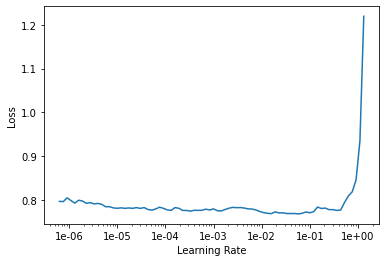

In [135]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

# load the encoder saved  
learn_classifier.load_encoder('/content/drive/MyDrive/ml/projects/darija/models/fine_tuned_enc')

learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# we typically find the point where the slope is steepest
learn_classifier.recorder.plot()

# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(5, 2e-2, moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

# Tune a little more
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(5, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

learn_classifier.show_results()

In [136]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = np.argmax(preds, axis =1)
target = test.Sentiment.map({"N":0,"P":1," P":1})

In [137]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
#plot_confusion_matrix(clf, X_test, y_test)  
#plt.show()

In [138]:
print(classification_report(target, labels))

              precision    recall  f1-score   support

           0       0.61      0.81      0.70       336
           1       0.72      0.50      0.59       342

    accuracy                           0.65       678
   macro avg       0.67      0.65      0.64       678
weighted avg       0.67      0.65      0.64       678



In [144]:
print(str(test.iloc[0].values))

['استاذ عفى لله عمى سلف من خصوص الشعب و ليس رئيس الحكورة يجب ان تطلب من الامة هل ستسامح ام لا يا ناقص اين الدين اين عدل عمر اين حزب العدالة اين عدالة اما هذه الارملة اذا سمحت باجرتك لشهر واحد عاشت بها سنة'
 'N']
